# Gymnasium With stablebaseline

In [652]:
from time import time
from enum import Enum
import gymnasium as gym
from gymnasium.envs.registration import register
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, CallbackList
import ta
import numpy as np
import logging
import pandas as pd
from sklearn.model_selection import train_test_split
import ta  # Ensure you have the ta library installed for technical analysis
import matplotlib.pyplot as plt  # For visualization
# hide warnings
import warnings
warnings.filterwarnings('ignore')

from time import time
from enum import Enum
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import gymnasium as gym
from gymnasium.envs.registration import register
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from stable_baselines3 import PPO, A2C, DQN, TD3
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.callbacks import (
    CheckpointCallback,
    EvalCallback,
    CallbackList,
)
from stable_baselines3.common.monitor import Monitor
from gymnasium import spaces
from gymnasium.utils import seeding
from sklearn.preprocessing import MinMaxScaler
import ta
import logging
from sklearn.impute import SimpleImputer
from datetime import datetime, timedelta
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
import sys
from typing import Any, Dict, Tuple, Union

# import mlflow

from stable_baselines3.common.logger import HumanOutputFormat, KVWriter, Logger

# lets hide the warnings
import warnings

warnings.filterwarnings("ignore")

In [653]:
df = pd.read_csv(
    "./data/currency_hourly_data.csv",
    parse_dates=["Date"],
    index_col="Date",
)

In [654]:
df.dropna(inplace=True)

In [655]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,11961.000000,11961.000000,11961.000000,11961.000000,11961.000000,11961.0
mean,1.065464,1.066154,1.064813,1.065471,1.065471,0.0
std,0.034673,0.034519,0.034816,0.034673,0.034673,0.0
min,0.954745,0.956389,0.954107,0.954290,0.954290,0.0
25%,1.056747,1.057306,1.056078,1.056747,1.056747,0.0
50%,1.076195,1.076774,1.075616,1.076195,1.076195,0.0
75%,1.088613,1.089206,1.088021,1.088613,1.088613,0.0
max,1.125999,1.127777,1.125366,1.126126,1.126126,0.0


In [656]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-07-14 00:00:00+01:00,1.005733,1.005834,1.003412,1.003613,1.003613,0.0
2022-07-14 01:00:00+01:00,1.003613,1.004621,1.002406,1.002406,1.002406,0.0
2022-07-14 02:00:00+01:00,1.002707,1.002908,1.001703,1.002104,1.002104,0.0
2022-07-14 03:00:00+01:00,1.002305,1.003110,1.001703,1.002406,1.002406,0.0
2022-07-14 04:00:00+01:00,1.002707,1.004319,1.002707,1.003613,1.003613,0.0


In [657]:
df.dropna(inplace=True)

In [658]:
df = df.ffill()

In [659]:
class Actions(Enum):
    Sell = 0
    Buy = 1
    Hold = 2

    def __int__(self):
        return self.value


class Positions(Enum):
    Short = 0
    Long = 1

    def __int__(self):
        return self.value

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

In [660]:
from typing import Tuple, Dict, Any, Optional


class TradingEnv(gym.Env):
    """
    A base class for creating trading environments in reinforcement learning.

    This class provides the basic structure and functionality for a trading environment,
    including state management, action handling, and rendering capabilities.
    """

    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 3}

    def __init__(
        self,
        df: np.ndarray,
        window_size: int,
        render_mode: Optional[str] = None,
        inf_value: float = 1e10,
    ):
        """
        Initialize the TradingEnv.

        Args:
            df (np.ndarray): The input data frame.
            window_size (int): The size of the observation window.
            render_mode (str, optional): The rendering mode. Defaults to None.
            inf_value (float, optional): The value to use for infinity in the observation space. Defaults to 1e10.
        """
        if df.ndim != 2:
            raise ValueError("Input df must be a 2-dimensional array")
        if render_mode is not None and render_mode not in self.metadata["render_modes"]:
            raise ValueError(
                f"Invalid render mode. Must be one of {self.metadata['render_modes']}"
            )

        self.render_mode = render_mode
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = gym.spaces.Discrete(len(Actions))
        self.observation_space = gym.spaces.Box(
            low=-inf_value,
            high=inf_value,
            shape=self.shape,
            dtype=np.float32,
        )

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._truncated = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None

        # Initialize plot for rendering
        self.fig, self.ax = plt.subplots()
        (self.price_line,) = self.ax.plot(self.prices)  # Store the plot line object
        self.position_scatter = None
        self._first_rendering = True
        self.history: Dict[str, list] = {}

    def reset(
        self, seed: Optional[int] = None, options: Optional[dict] = None
    ) -> Tuple[np.ndarray, Dict[str, Any]]:
        """
        Reset the environment to its initial state.

        Args:
            seed (int, optional): Seed for random number generator.
            options (dict, optional): Additional options for reset.

        Returns:
            Tuple[np.ndarray, Dict[str, Any]]: Initial observation and info dictionary.
        """
        super().reset(seed=seed, options=options)
        self.action_space.seed(
            int((self.np_random.uniform(0, seed if seed is not None else 1)))
        )

        self._truncated = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.0
        self._total_profit = 1.0  # unit
        self._first_rendering = True
        self.history = {}

        # Clear the plot on reset
        self.ax.cla()
        (self.price_line,) = self.ax.plot(self.prices)
        self.position_scatter = None

        observation = self._get_observation()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, Any]]:
        """
        Take a step in the environment.

        Args:
            action (int): The action to take.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, Any]]:
            Observation, reward, terminated, truncated, and info dictionary.
        """
        self._truncated = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._truncated = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if (action == Actions.Buy.value and self._position == Positions.Short) or (
            action == Actions.Sell.value and self._position == Positions.Long
        ):
            trade = True

        if trade:
            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = self._get_info()
        self._update_history(info)

        if self.render_mode == "human":
            self._render_frame()

        return observation, step_reward, False, self._truncated, info

    def _get_info(self) -> Dict[str, Any]:
        """
        Get the current state information.

        Returns:
            Dict[str, Any]: Dictionary containing current state information.
        """
        return dict(
            total_reward=self._total_reward,
            total_profit=self._total_profit,
            position=self._position,
        )

    def _get_observation(self) -> np.ndarray:
        """
        Get the current observation.

        Returns:
            np.ndarray: The current observation.
        """
        return self.signal_features[
            (self._current_tick - self.window_size + 1) : self._current_tick + 1
        ]

    def _update_history(self, info: Dict[str, Any]) -> None:
        """
        Update the history with the current info.

        Args:
            info (Dict[str, Any]): The current state information.
        """
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    def _render_frame(self) -> None:
        """Render the current frame."""
        self.render()

    def render(self) -> None:
        """Render the current state of the environment."""
        start_time = time()

        # Update price plot
        self.price_line.set_data(np.arange(len(self.prices)), self.prices)
        self.ax.set_xlim(0, len(self.prices))
        self.ax.set_ylim(min(self.prices), max(self.prices))

        # Update position markers
        if self.position_scatter is not None:
            self.position_scatter.remove()

        short_ticks = [
            i for i, pos in enumerate(self._position_history) if pos == Positions.Short
        ]
        long_ticks = [
            i for i, pos in enumerate(self._position_history) if pos == Positions.Long
        ]

        self.position_scatter = self.ax.scatter(
            short_ticks, self.prices[short_ticks], color="red", marker="o"
        )
        self.position_scatter = self.ax.scatter(
            long_ticks, self.prices[long_ticks], color="green", marker="o"
        )

        # Update plot title
        self.ax.set_title(
            f"Total Reward: {self._total_reward:.6f} ~ Total Profit: {self._total_profit:.6f}"
        )

        # Update the plot
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

        end_time = time()
        process_time = end_time - start_time

        pause_time = (1 / self.metadata["render_fps"]) - process_time
        if pause_time <= 0:
            raise RuntimeError("High FPS! Try to reduce the 'render_fps' value.")

        plt.pause(pause_time)

    def render_all(self, title: Optional[str] = None) -> None:
        """
        Render the entire trading history.

        Args:
            title (str, optional): Title for the plot.
        """
        plt.figure(figsize=(20, 16))

        # Plot prices
        plt.plot(self.prices)

        # Plot position markers
        short_ticks = [
            i for i, pos in enumerate(self._position_history) if pos == Positions.Short
        ]
        long_ticks = [
            i for i, pos in enumerate(self._position_history) if pos == Positions.Long
        ]

        plt.plot(short_ticks, [self.prices[i] for i in short_ticks], "ro")
        plt.plot(long_ticks, [self.prices[i] for i in long_ticks], "go")

        plt.tight_layout()

        if title:
            plt.title(title)

        plt.suptitle(
            f"Total Reward: {self._total_reward:.6f} ~ Total Profit: {self._total_profit:.6f}"
        )

    def close(self) -> None:
        """Close the environment and release resources."""
        plt.close(self.fig)

    def save_rendering(self, filepath: str) -> None:
        """
        Save the current rendering to a file.

        Args:
            filepath (str): Path to save the rendering.
        """
        plt.savefig(filepath)

    def pause_rendering(self) -> None:
        """Pause the rendering and show the plot."""
        plt.show()

    def _process_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Process the input data to extract prices and signal features.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Processed prices and signal features.
        """
        raise NotImplementedError("This method should be implemented in a subclass")

    def _calculate_reward(self, action: int) -> float:
        """
        Calculate the reward for the given action.

        Args:
            action (int): The action taken.

        Returns:
            float: The calculated reward.
        """
        raise NotImplementedError("This method should be implemented in a subclass")

    def _update_profit(self, action: int) -> None:
        """
        Update the total profit based on the action taken.

        Args:
            action (int): The action taken.
        """
        raise NotImplementedError("This method should be implemented in a subclass")

In [661]:
class ForexEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound, unit_side='left', 
                 render_mode=None, trade_fee=0.0003, spread=0.0001, lot_size=0.01,leverage=50,
                 stop_loss=0.001, take_profit=0.002):
        assert len(frame_bound) == 2
        assert unit_side.lower() in ['left', 'right']

        self.frame_bound = frame_bound
        self.unit_side = unit_side.lower()
        super().__init__(df, window_size, render_mode)

        self.lot_size = lot_size
        self.leverage = leverage
        self.spread = spread  # Pip spread
        self.trade_fee = trade_fee  # Fee per lot
        self.unit_side = unit_side.lower()
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        self._total_profit = 1.0

    def _process_data(self):
        # Validate frame_bound and window_size
        if not (0 <= self.frame_bound[0] - self.window_size < len(self.df)):
            raise ValueError("frame_bound and window_size combination is out of range.")
        if not (self.frame_bound[1] <= len(self.df)):
            raise ValueError("frame_bound end is out of range.")

        self.df.dropna(inplace=True)
        # Extract relevant data within the frame_bound
        start_index = max(0, self.frame_bound[0] - self.window_size)
        end_index = self.frame_bound[1]
        data_slice = self.df.iloc[start_index:end_index]
        # # Combine relevant columns into signal features
        # signal_features = data_slice[
        #     [
        # "Volume",
        # "RSI",
        # "Rolling_Returns_30d",
        # "Close_StdDev_7",
        # "SMA_50",
        # "SMA_200",
        # "SMA_20",
        # "EMA",
        # "ATR",
        # "Close_Lag_1",
        # "Open_Lag_1",
        # "High_Lag_1",
        # "Low_Lag_1",
        # "Low_Lag_2",
        # "Close_Lag_2",
        # "High_Lag_2",
        # "Open_Lag_2",
        # "Day",
        # "Hour",
        # "Volatility",
        # "Momentum",
        # "Bollinger_High",
        # "Bollinger_Low",
        # "MACD",
        # "High",
        # "Low",
        # "Close",
        # "Open",
        # "Cumulative_Returns",
        #     ]
        # ]
        # Feature columns
        feature_columns = [
            "High",
            "Low",
            "Close",
            "Open",
            "SMA_200",
            "SMA_50",
            "EMA",
            "RSI",
            "Bollinger_High",
            "Bollinger_Low",
            "MACD",
            "Returns",
            "ATR",
            "Volatility",
            "Momentum",
            "Close_StdDev_7",
        ]
        signal_features = data_slice[feature_columns]
        # Normalize signal features using standardization
        scaler = StandardScaler()
        signal_features = scaler.fit_transform(signal_features)

        # Replace NaNs with zeros
        signal_features = np.nan_to_num(signal_features)

        return data_slice['Close'].astype(np.float32).values, signal_features.astype(np.float32)

    def _calculate_reward(self, action):
        step_reward = 0
        trade = False

        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price

            # Calculate pip profit (adjust for lot size, leverage, spread, and fee)
            if self._position == Positions.Short:
                step_reward += -price_diff * self.lot_size * self.leverage * 10000
                step_reward -= self.spread * self.lot_size * self.leverage * 10000  # Spread
            elif self._position == Positions.Long:
                step_reward += price_diff * self.lot_size * self.leverage * 10000
                step_reward -= self.spread * self.lot_size * self.leverage * 10000  # Spread

            step_reward -= self.trade_fee * self.lot_size * self.leverage * 10000  # Fee

        return step_reward

    def _update_profit(self, action):
        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade or self._truncated:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self.unit_side == 'left':
                if self._position == Positions.Short:
                    quantity = self._total_profit * (last_trade_price - self.trade_fee)
                    self._total_profit = quantity / current_price

            elif self.unit_side == 'right':
                if self._position == Positions.Long:
                    quantity = self._total_profit / last_trade_price
                    self._total_profit = quantity * (current_price - self.trade_fee)

            logging.info(f"Updated profit: {self._total_profit}")

    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.0

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            current_price = self.prices[current_tick - 1]
            last_trade_price = self.prices[last_trade_tick]

            if self.unit_side == 'left':
                if position == Positions.Short:
                    quantity = profit * (last_trade_price - self.trade_fee)
                    profit = quantity / current_price

            elif self.unit_side == 'right':
                if position == Positions.Long:
                    quantity = profit / last_trade_price
                    profit = quantity * (current_price - self.trade_fee)

            last_trade_tick = current_tick - 1

        return profit

In [662]:
def add_technical_indicators(df):
    # Calculate technical indicators using TA-Lib
    df["RSI"] = ta.momentum.RSIIndicator(close=df["Close"], window=14).rsi()
    df["SMA_20"] = ta.trend.SMAIndicator(
        close=df["Close"], window=20
    ).sma_indicator()

    bollinger = ta.volatility.BollingerBands(close=df["Close"], window=20)
    df["Bollinger_High"] = bollinger.bollinger_hband()
    df["Bollinger_Low"] = bollinger.bollinger_lband()

    macd = ta.trend.MACD(
        close=df["Close"], window_fast=12, window_slow=26, window_sign=9
    )
    df["MACD"] = macd.macd()

    # Add new indicators
    df["EMA"] = ta.trend.EMAIndicator(close=df["Close"], window=20).ema_indicator()
    df["ATR"] = ta.volatility.AverageTrueRange(
        high=df["High"], low=df["Low"], close=df["Close"], window=14
    ).average_true_range()
    # df["VWAP"] = (df["Close"] * df["Volume"]).cumsum() / df["Volume"].cumsum()
    df["SMA_50"] = df["Close"].rolling(window=50).mean()
    df["SMA_200"] = df["Close"].rolling(window=200).mean()

    # Create lagged features
    for lag in range(1, 4):  # Create lags for the last 3 time steps
        df[f"Close_Lag_{lag}"] = df["Close"].shift(lag)
        df[f"Open_Lag_{lag}"] = df["Open"].shift(lag)
        df[f"High_Lag_{lag}"] = df["High"].shift(lag)
        df[f"Low_Lag_{lag}"] = df["Low"].shift(lag)

    # Ensure the index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, errors="coerce")

    # Create time-based features
    df["Month"] = df.index.month
    df["Day"] = df.index.day
    df["Hour"] = df.index.hour

    # Calculate rolling standard deviation (7-period)
    df["Close_StdDev_7"] = df["Close"].rolling(window=7).std()

    # Calculate rolling returns
    df["Rolling_Returns_30d"] = df["Close"].pct_change().rolling(window=30).sum()
    df["Cumulative_Returns"] = df["Close"].pct_change().cumsum()
    # Daily returns to capture price changes
    df["Returns"] = df["Close"].pct_change()
    # Volatility as a measure of risk
    df["Volatility"] = df["Returns"].rolling(window=20).std()

    # Momentum indicator to capture the strength of price trends
    df["Momentum"] = df["Close"] / df["Close"].shift(20) - 1

    return df

In [663]:
df = add_technical_indicators(df)
df.dropna(inplace=True)

In [664]:
len(df)

6679

In [665]:
# Load test data and evaluate the model
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

In [666]:
len(train_data), len(test_data)

(5343, 1336)

In [667]:
train_data.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA_20,Bollinger_High,Bollinger_Low,...,Low_Lag_3,Month,Day,Hour,Close_StdDev_7,Rolling_Returns_30d,Cumulative_Returns,Returns,Volatility,Momentum
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-26 09:00:00+01:00,1.022390,1.022390,1.020616,1.021033,1.021033,0.0,44.423519,1.022627,1.024694,1.020559,...,1.021764,7.0,26.0,9.0,0.001138,-0.000288,0.017493,-0.001634,0.001020,-0.003676
2022-07-26 10:00:00+01:00,1.020929,1.021242,1.017708,1.017812,1.017812,0.0,34.667844,1.022261,1.024934,1.019589,...,1.021451,7.0,26.0,10.0,0.001843,-0.003443,0.014338,-0.003155,0.001209,-0.007125
2022-07-26 11:00:00+01:00,1.017605,1.017915,1.013890,1.015435,1.015435,0.0,29.517179,1.021929,1.025931,1.017928,...,1.021242,7.0,26.0,11.0,0.002764,-0.005472,0.012002,-0.002335,0.001144,-0.006499
2022-07-26 12:00:00+01:00,1.015022,1.015435,1.012863,1.013685,1.013685,0.0,26.406832,1.021557,1.026935,1.016178,...,1.020616,7.0,26.0,12.0,0.003506,-0.006278,0.010279,-0.001723,0.001180,-0.007298
2022-07-26 13:00:00+01:00,1.013479,1.014713,1.012043,1.014713,1.014713,0.0,31.009125,1.021173,1.027302,1.015044,...,1.017708,7.0,26.0,13.0,0.003633,-0.005161,0.011294,0.001015,0.001166,-0.007509


In [668]:
register(
    id="forex-v0",
    entry_point=ForexEnv,
    kwargs={"df": train_data, "window_size": 20, "frame_bound": (25, len(train_data))},
)

### Build Environment and Train

In [669]:
env_maker = lambda: gym.make(
    "forex-v0", df=train_data, frame_bound=(30, len(train_data)), window_size=20
)
env = DummyVecEnv([env_maker])

In [670]:
# Callbacks for monitoring and saving
checkpoint_callback = CheckpointCallback(save_freq=100000, save_path='./models/', name_prefix='ppo_forex')
env_maker = lambda: gym.make(
    "forex-v0", df=train_data, frame_bound=(20, 2000), window_size=20
)
eval_env = DummyVecEnv([env_maker])
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/', log_path='./logs/', eval_freq=50000)

# List of callbacks
callback = CallbackList([checkpoint_callback, eval_callback])

In [671]:
# Train the model with tuned hyperparameters
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0001,  # Lower learning rate for stability
    n_steps=2048,  # Increase n_steps for faster training
    batch_size=64,  # Increase batch size for better gradient updates
    n_epochs=30,  # Reduce n_epochs to shorten training time
    gamma=0.99,  # Discount factor for future rewards
    gae_lambda=0.95,  # Adjust for bias-variance trade-off
    clip_range=0.2,  # Keep as is, but can experiment with 0.1 to 0.3
    ent_coef=0.01,  # Encourage more exploration (optional)
    vf_coef=0.5,  # Balance value function and policy importance
    max_grad_norm=0.5,  # Control gradient norm for stability
)

Using cpu device


In [ ]:
# Set custom logger
model.learn(total_timesteps=6000000, log_interval=1, callback=callback)

-----------------------------
| time/              |      |
|    fps             | 251  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 31          |
|    iterations           | 2           |
|    time_elapsed         | 131         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005692848 |
|    clip_fraction        | 0.0258      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.00097    |
|    learning_rate        | 0.0001      |
|    loss                 | 649         |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00657    |
|    value_loss           | 1.26e+03    |
-----------------------------------------
Eval num_timesteps=5000, episode_r

In [632]:
model_name = "trader_usd_eur_ppo"

In [633]:
model.save(model_name)

### Evaluation

In [634]:
from stable_baselines3.common.evaluation import evaluate_policy

# --- Evaluation ---

# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean Reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Mean Reward: 2589.44 +/- 0.00


Mean Reward: -122.16 +/- 0.00


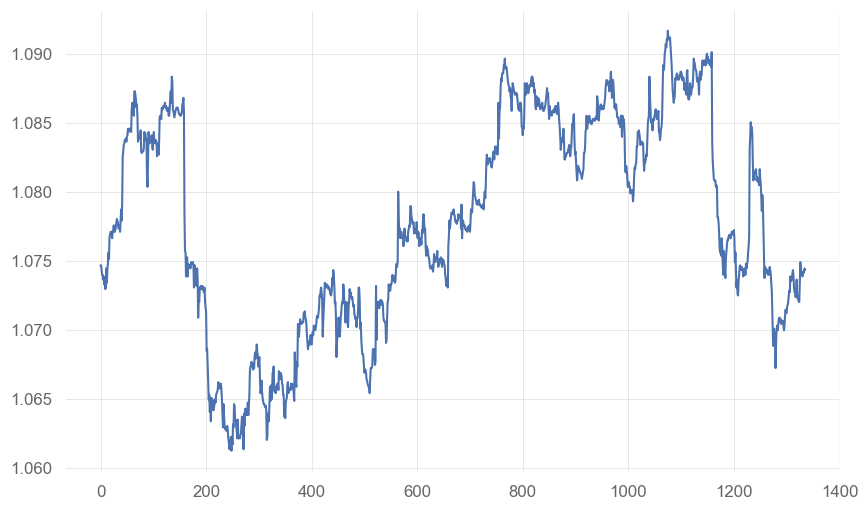

In [635]:
import plotly.graph_objects as go


# --- Evaluation ---

# Load the trained model
model_name = "trader_usd_eur_ppo.zip"
model = PPO.load(model_name)

# Define the environment for evaluation
env_maker = lambda: gym.make(
    "forex-v0", df=test_data, frame_bound=(20, len(test_data)), window_size=20
)
eval_env = DummyVecEnv([env_maker])

# Evaluate the model
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
print(f"Mean Reward: {mean_reward:.2f} +/- {std_reward:.2f}")

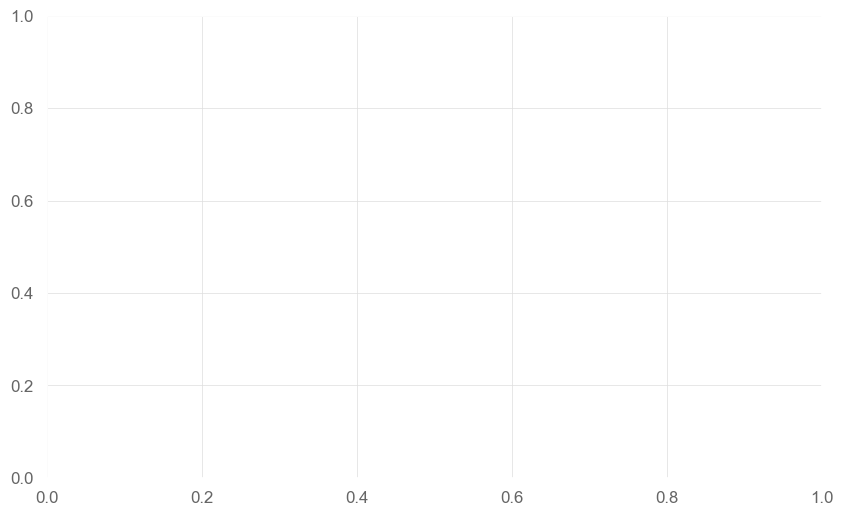

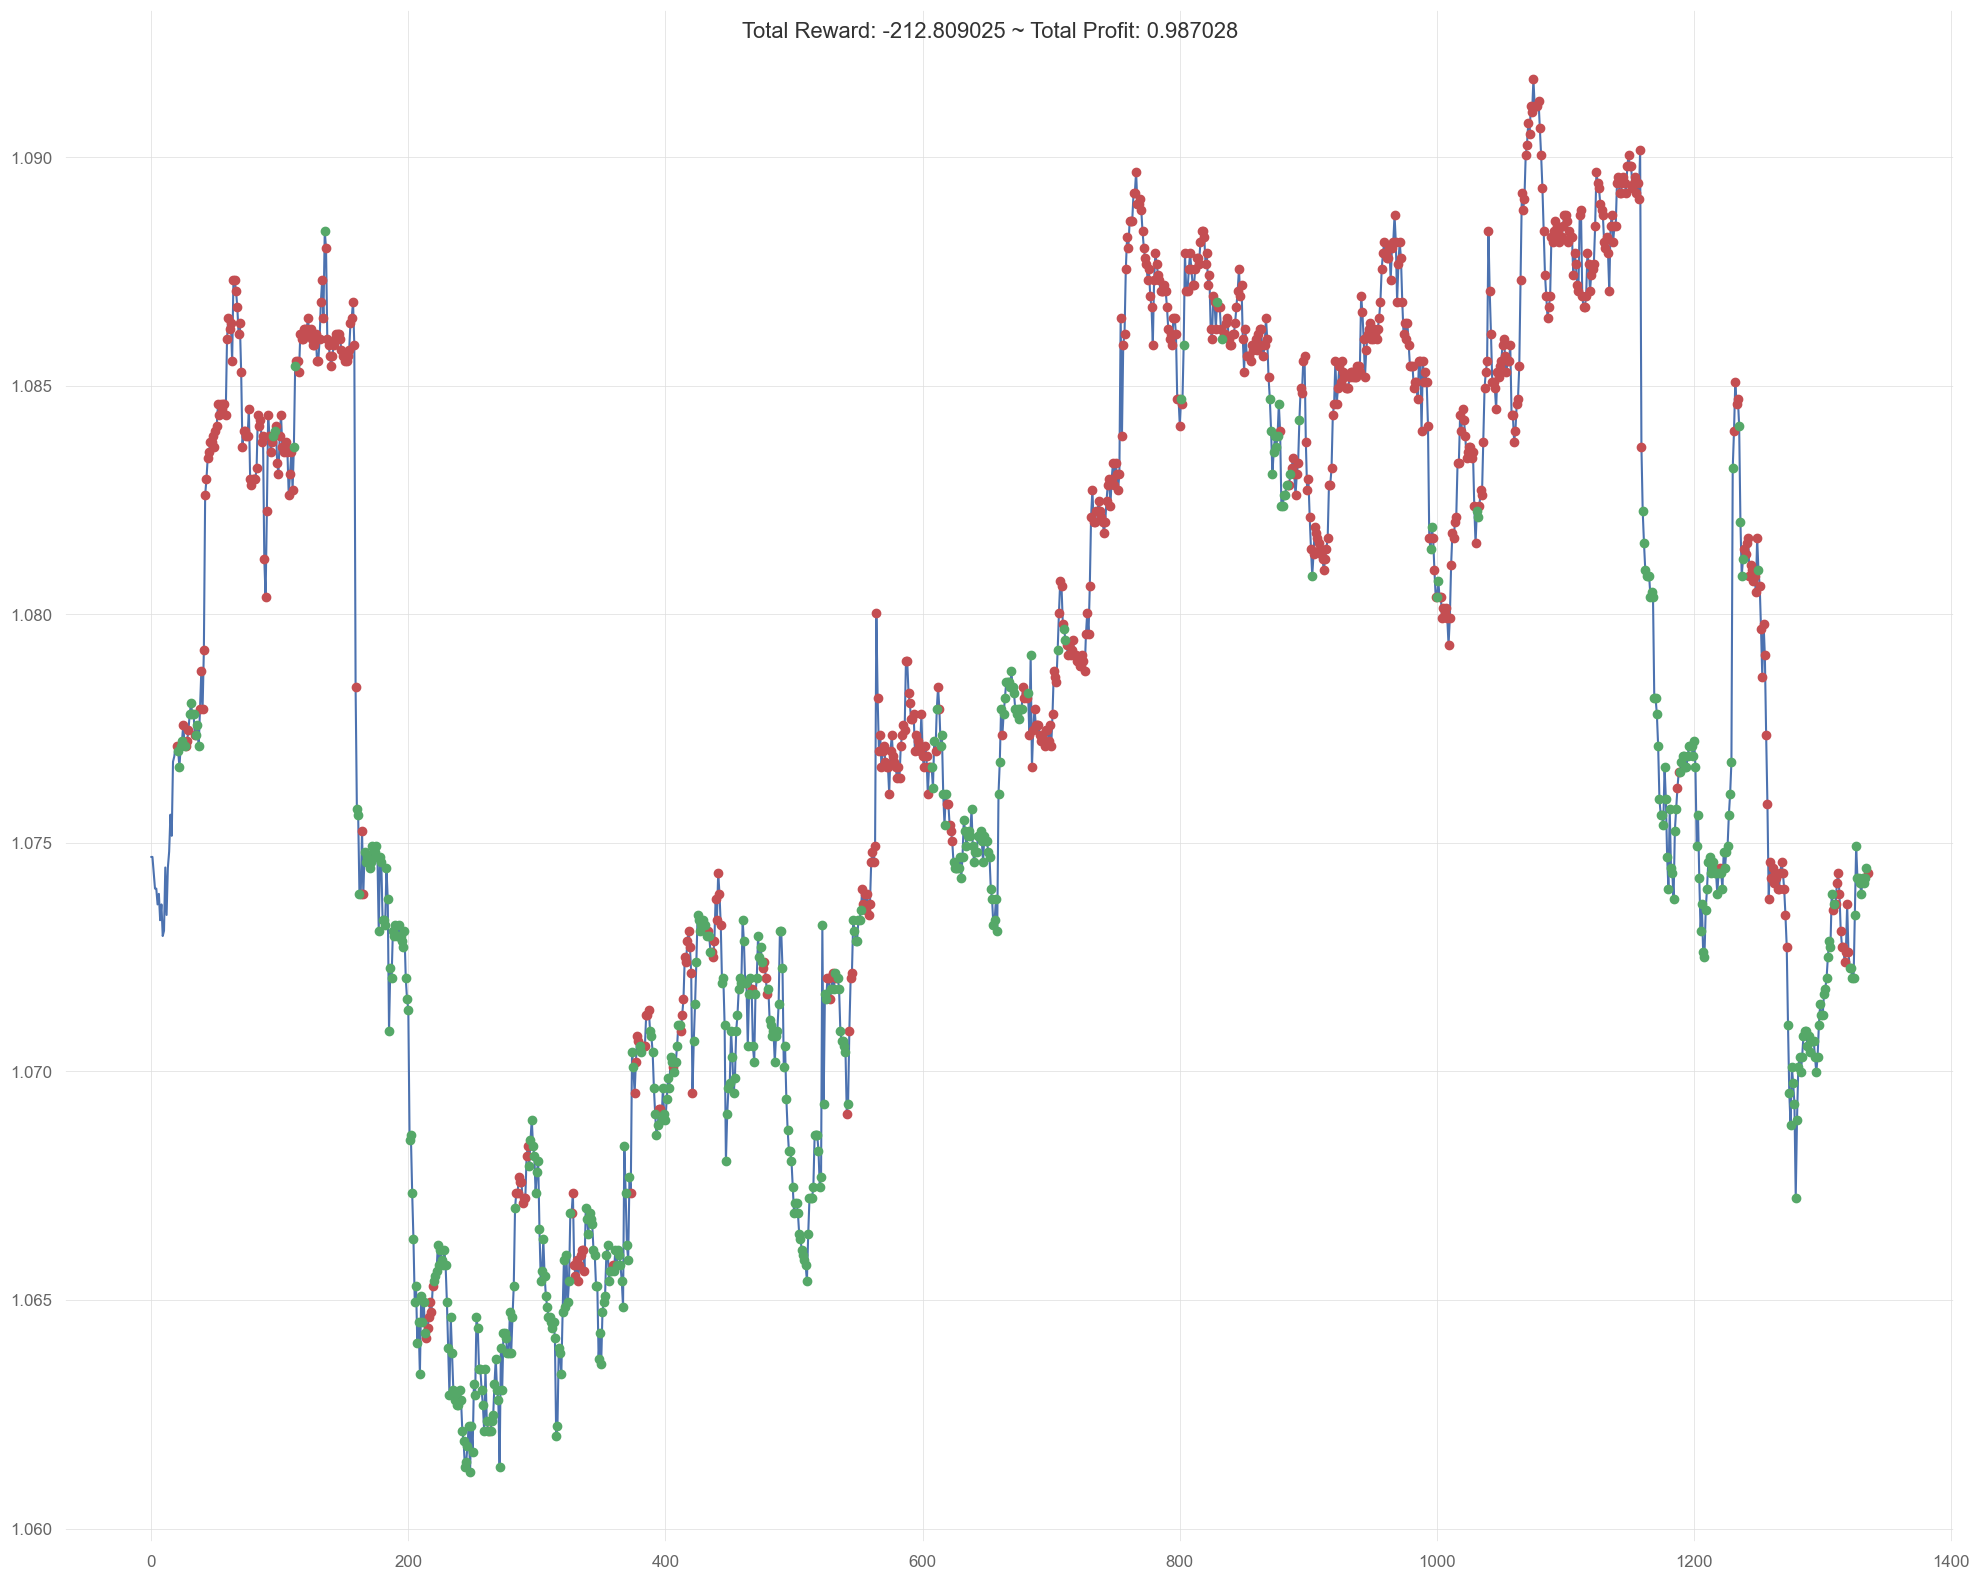

In [636]:
# Initialize the gym environment and your model as usual
env = gym.make('forex-v0', df=test_data, frame_bound=(20, len(test_data)), window_size=20)
obs, _ = env.reset()
del model

# Load the trained model
model = PPO.load(model_name)

# Turn on interactive plotting
plt.ion()

while True:
    action, _states = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        # print("info:", info, obs)
        break

# Turn off interactive plotting and show the final plot
plt.cla()
env.unwrapped.render_all()
plt.show()

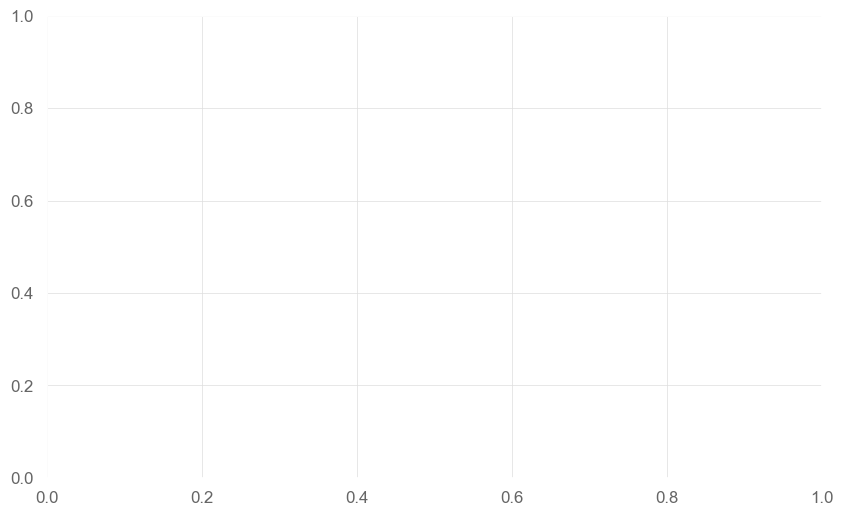

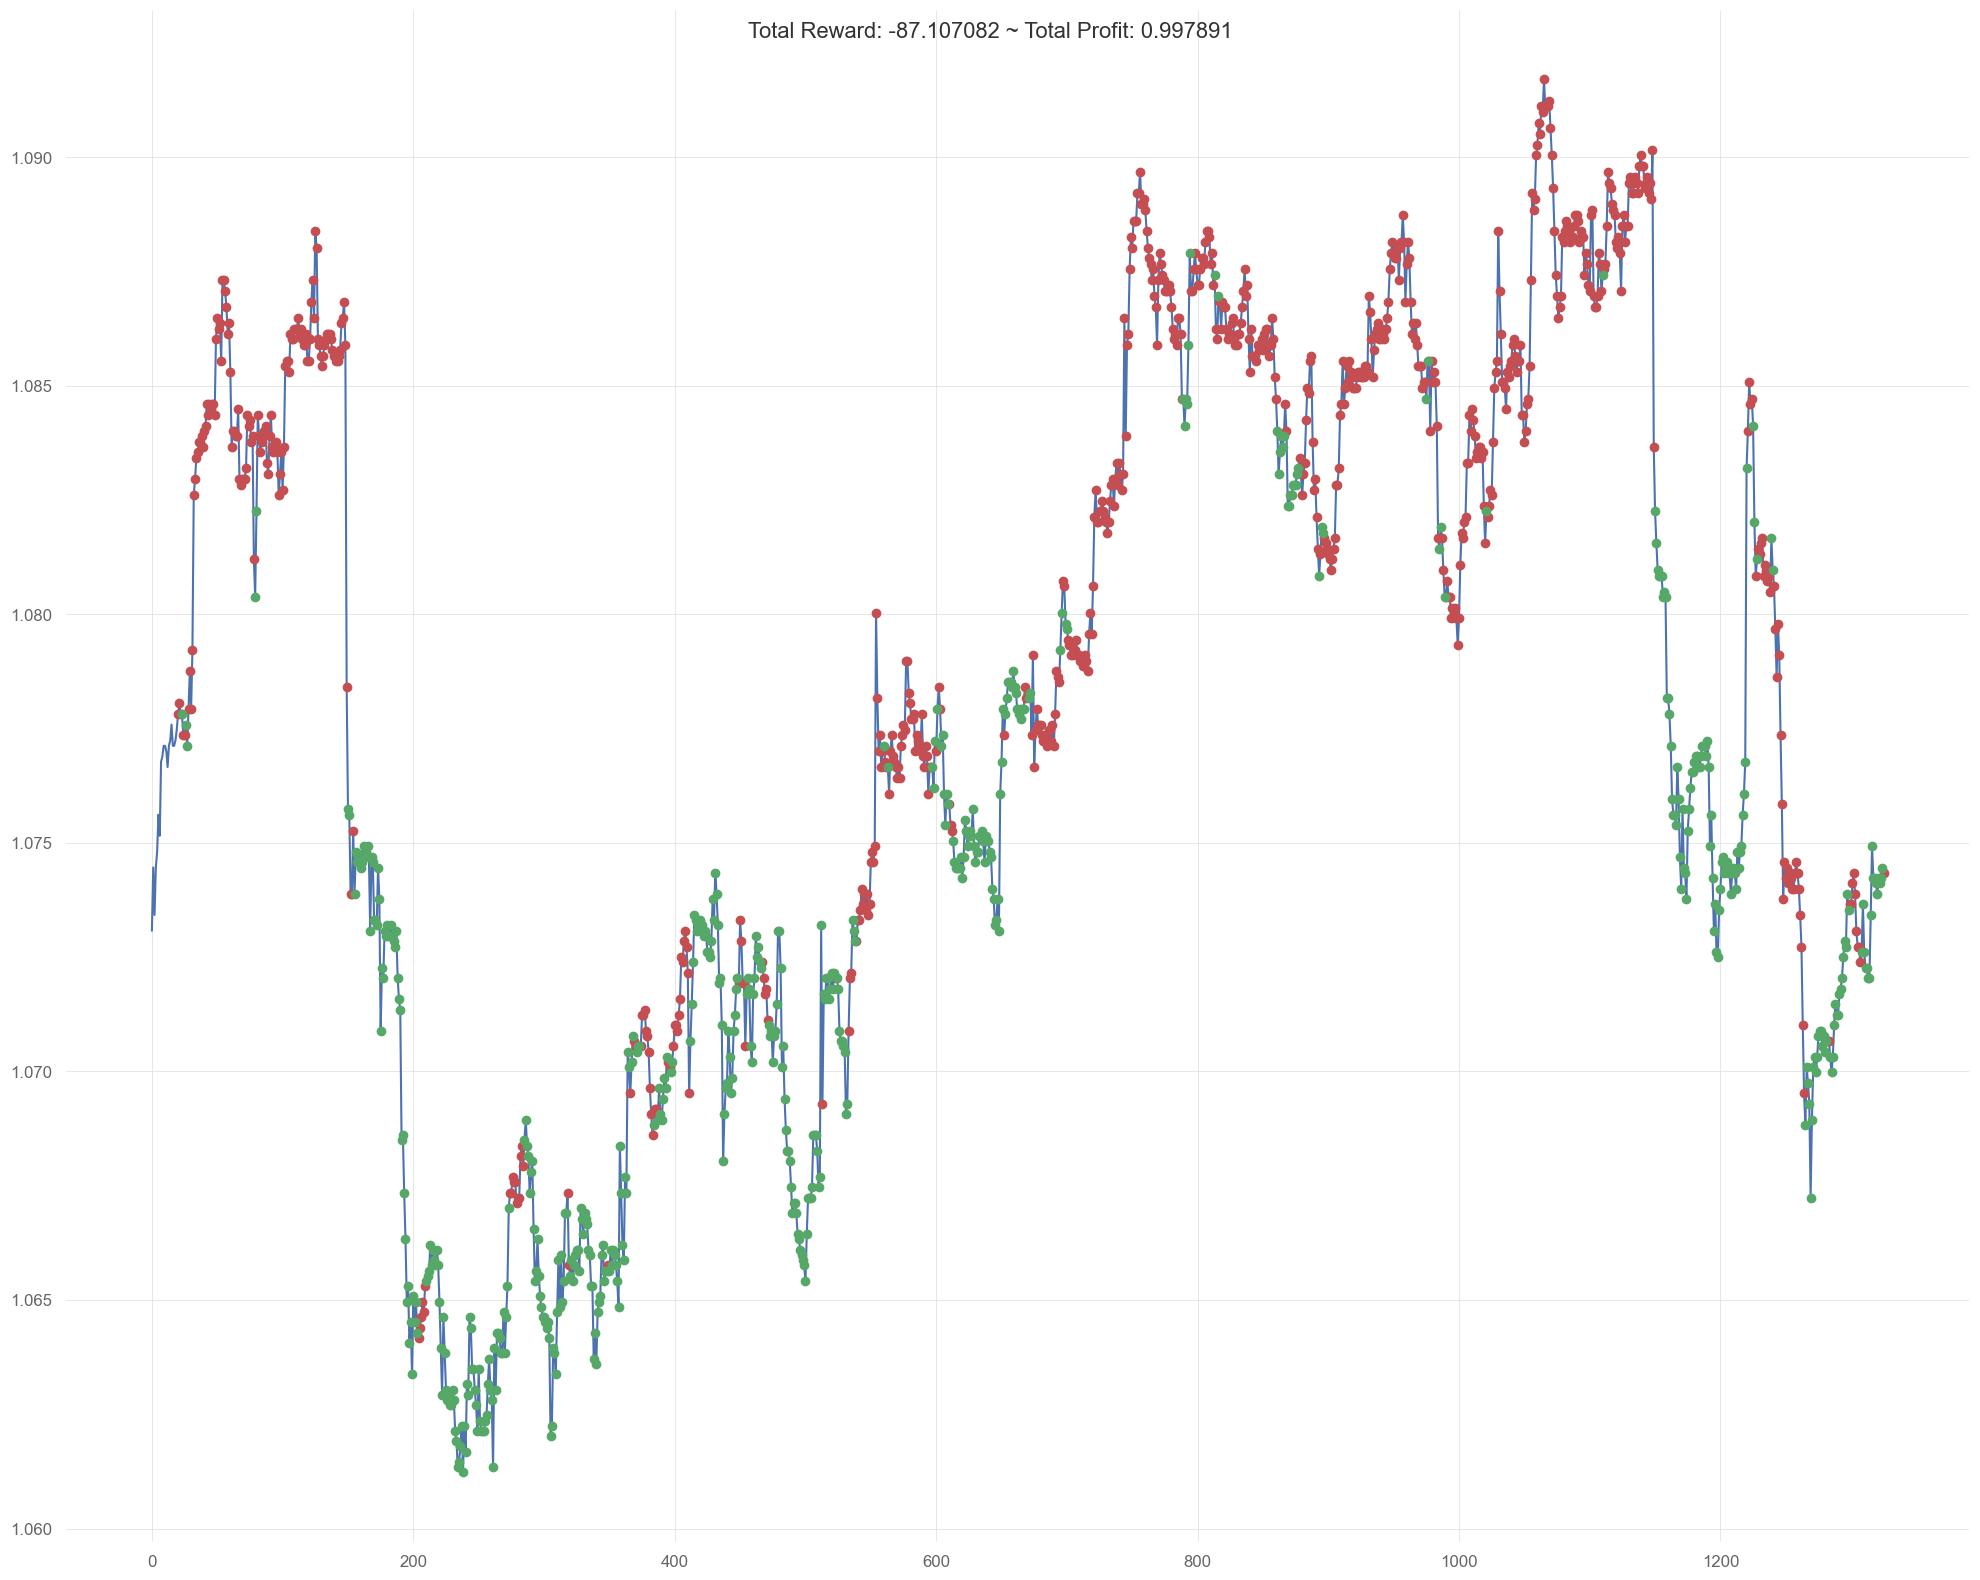

Total Reward: -87.10708236694336
Performance report saved as trading_performance_report_20241029_044731.html


In [637]:
import quantstats as qs
from datetime import datetime


def evaluate_rl_model(model, test_data):
    # Create the environment with the test data
    env = gym.make(
        "forex-v0", df=test_data, frame_bound=(30, len(test_data)), window_size=20
    )
    obs, _ = env.reset()
    total_reward = 0
    rewards = []
    done = False
    step = 0

    # Ensure index is DatetimeIndex
    if not isinstance(test_data.index, pd.DatetimeIndex):
        test_data.index = pd.to_datetime(test_data.index)

    # Convert to timezone-naive datetime objects if necessary
    if test_data.index.tz is not None:
        test_data.index = test_data.index.tz_localize(None)

    test_data = test_data.sort_index()
    dates = test_data.index  # Get the index (dates) from test_data

    # Turn on interactive plotting
    plt.ion()
    while not done:
        action, _states = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        rewards.append(reward)  # Make sure reward is a scalar value
        done = terminated or truncated  # Update done status
        step += 1

    # Turn off interactive plotting and show the final plot
    plt.cla()
    env.unwrapped.render_all()
    plt.show()

    # Create a rewards series with the test data's index (DatetimeIndex)
    rewards_series = pd.Series(
        rewards, index=dates[: len(rewards)]
    )  # Align rewards with dates

    # Calculate cumulative returns from rewards, assuming an initial balance of 10000
    returns = rewards_series.cumsum() / 10000

    # Ensure the returns have the same length as the test data
    returns = returns[: len(test_data)]

    # Ensure returns index is DatetimeIndex
    if not isinstance(returns.index, pd.DatetimeIndex):
        returns.index = pd.to_datetime(returns.index)

    # Use quantstats to generate performance report with cumulative returns
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"trading_performance_report_{timestamp}.html"
    qs.reports.html(returns, output=output_file)

    print(f"Total Reward: {total_reward}")
    print(f"Performance report saved as {output_file}")
    return total_reward


# Assuming forex_df is your original dataframe
# Ensure the index is a DatetimeIndex
if not isinstance(test_data.index, pd.DatetimeIndex):
    test_data.index = pd.to_datetime(test_data.index)


# Evaluate the model using test data
total_reward = evaluate_rl_model(model, test_data)

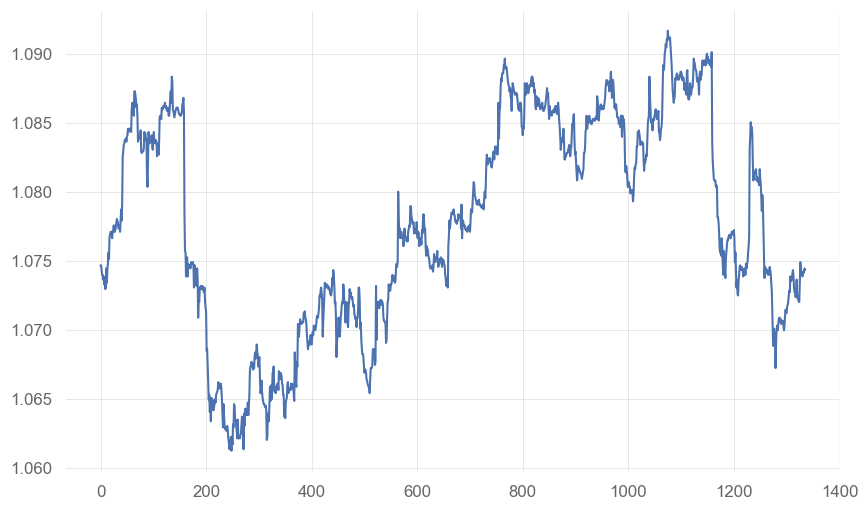

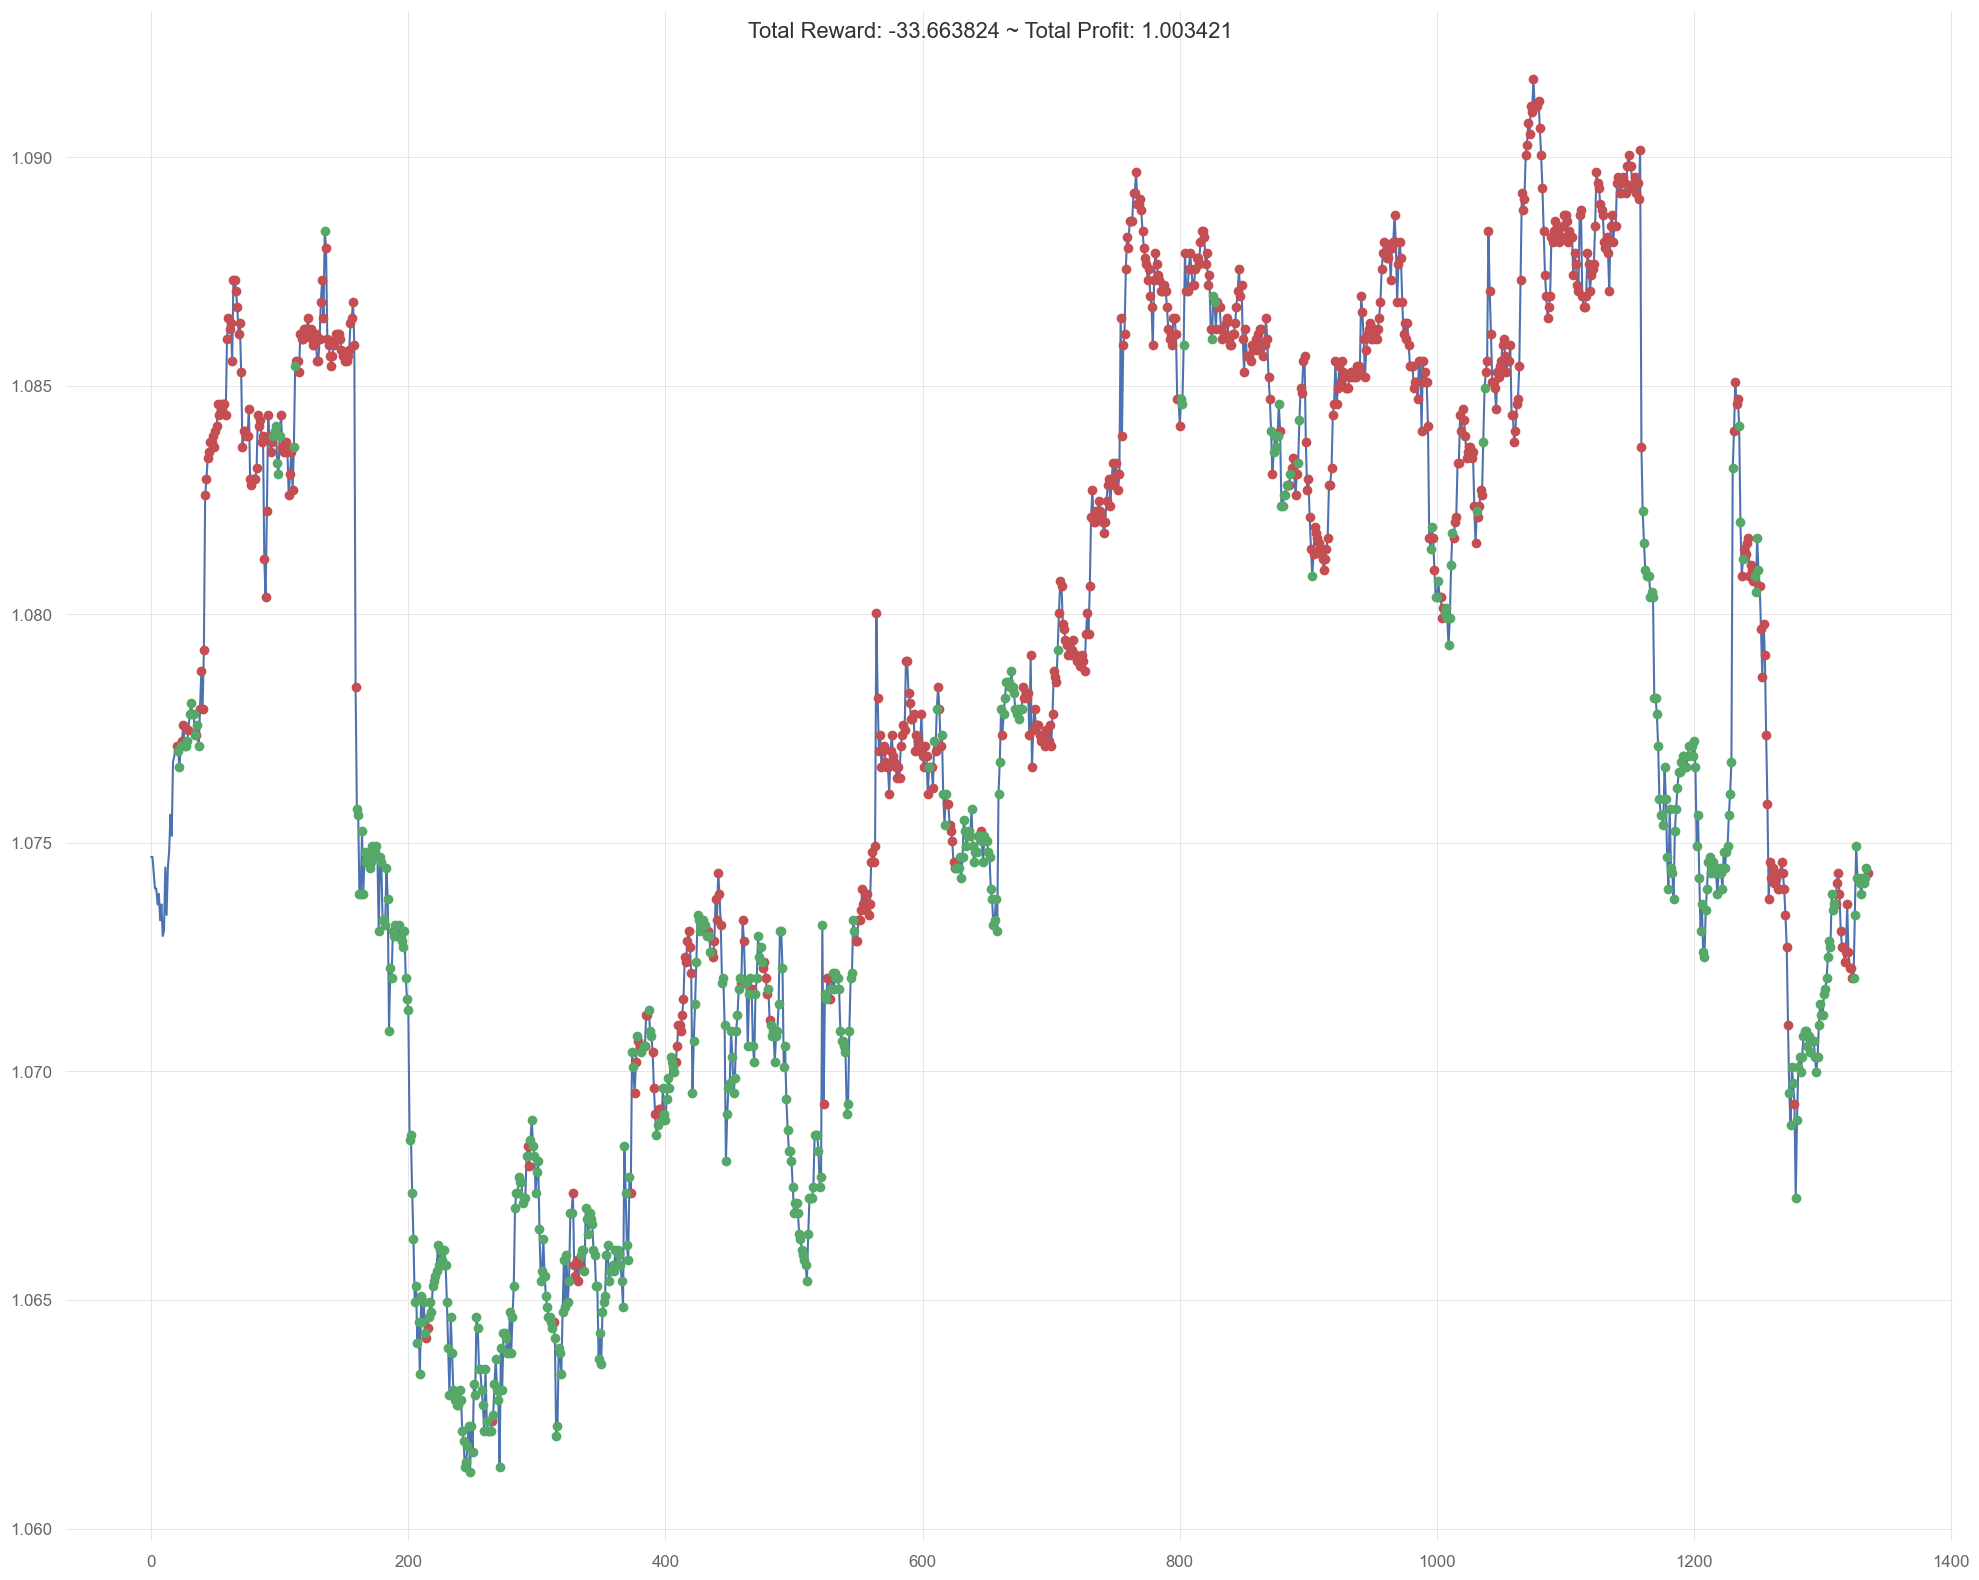

sma performance report saved as: reports/sma_report_20241029_092931.html
rl performance report saved as: reports/rl_report_20241029_093009.html


In [651]:
import numpy as np
import pandas as pd
import quantstats as qs
import gymnasium as gym
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Optional, Union, Tuple, Any
from pandas import DataFrame, Series
from pathlib import Path


class TradingStrategyEvaluator:
    """
    A class to evaluate different trading strategies including RL models,
    Buy & Hold, and Simple Moving Average strategies.
    """

    def __init__(
        self,
        initial_balance: float = 10000.0,
        short_window: int = 20,
        long_window: int = 50,
        output_dir: str = "reports",
    ):
        """
        Initialize the evaluator with trading parameters.

        Args:
            initial_balance: Initial trading balance
            short_window: Short-term moving average window
            long_window: Long-term moving average window
            output_dir: Directory to save performance reports
        """
        self.initial_balance = initial_balance
        self.short_window = short_window
        self.long_window = long_window
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)

    def _prepare_data(self, data: DataFrame) -> DataFrame:
        """
        Prepare and validate the input data.

        Args:
            data: Input DataFrame with trading data

        Returns:
            Processed DataFrame with proper datetime index
        """
        if not isinstance(data.index, pd.DatetimeIndex):
            data.index = pd.to_datetime(data.index)

        if data.index.tz is not None:
            data.index = data.index.tz_localize(None)

        required_columns = {"Close"}
        missing_columns = required_columns - set(data.columns)
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

        return data.sort_index()

    def _process_returns(self, returns: Series) -> Series:
        """
        Process returns to ensure they are suitable for QuantStats analysis.

        Args:
            returns: Raw returns series

        Returns:
            Processed returns series
        """
        # Remove any infinite values
        returns = returns.replace([np.inf, -np.inf], np.nan)

        # Forward fill NaN values for continuity
        returns = returns.fillna(method="ffill")

        # If still any NaN values at the start, backward fill
        returns = returns.fillna(method="bfill")

        # Convert to percentage returns if not already
        if (returns.abs() > 1).any():
            returns = returns / 100.0

        return returns

    def evaluate_rl_strategy(
        self, model: Any, data: DataFrame, window_size: int = 20
    ) -> Series:
        """
        Evaluate a reinforcement learning trading model.

        Args:
            model: Trained RL model with predict method
            data: DataFrame containing the test data
            window_size: Size of the observation window

        Returns:
            Series containing returns (not cumulative)
        """
        try:
            env = gym.make(
                "forex-v0",
                df=data,
                frame_bound=(window_size, len(data)),
                window_size=window_size,
            )
            obs, _ = env.reset()
            rewards = []
            done = False

            plt.ion()  # Enable interactive mode

            while not done:
                action, _ = model.predict(obs)
                obs, reward, terminated, truncated, _ = env.step(action)
                rewards.append(reward)
                done = terminated or truncated

            plt.ioff()  # Disable interactive mode
            env.unwrapped.render_all()
            plt.show()

            # Convert rewards to returns format
            returns = pd.Series(
                rewards, index=data.index[window_size : window_size + len(rewards)]
            )

            return self._process_returns(returns)

        except Exception as e:
            plt.ioff()  # Ensure interactive mode is disabled on error
            raise RuntimeError(f"RL strategy evaluation failed: {str(e)}")

    def evaluate_buy_and_hold(self, data: DataFrame) -> Series:
        """
        Evaluate a simple buy and hold strategy.

        Args:
            data: DataFrame containing the test data

        Returns:
            Series containing returns (not cumulative)
        """
        returns = data["Close"].pct_change()
        return self._process_returns(returns)

    def evaluate_sma_strategy(self, data: DataFrame) -> Series:
        """
        Evaluate a Simple Moving Average (SMA) crossing strategy.

        Args:
            data: DataFrame containing the test data

        Returns:
            Series containing returns (not cumulative)
        """
        short_ma = data["Close"].rolling(window=self.short_window).mean()
        long_ma = data["Close"].rolling(window=self.long_window).mean()

        signals = pd.Series(index=data.index)
        signals[short_ma > long_ma] = 1  # Buy signal
        signals[short_ma <= long_ma] = -1  # Sell signal

        returns = signals.shift(1) * data["Close"].pct_change()
        return self._process_returns(returns)

    def generate_report(
        self,
        returns: Series,
        strategy_name: str,
        benchmark_returns: Optional[Series] = None,
    ) -> str:
        """
        Generate and save a performance report using QuantStats.

        Args:
            returns: Series of strategy returns (not cumulative)
            strategy_name: Name of the strategy for the report
            benchmark_returns: Optional benchmark returns for comparison

        Returns:
            Path to the generated report
        """
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_file = self.output_dir / f"{strategy_name}_report_{timestamp}.html"

        # Ensure returns and benchmark_returns have matching dates
        if benchmark_returns is not None:
            common_dates = returns.index.intersection(benchmark_returns.index)
            returns = returns[common_dates]
            benchmark_returns = benchmark_returns[common_dates]

            qs.reports.html(
                returns,
                benchmark=benchmark_returns,
                output=str(output_file),
                title=f"{strategy_name} Analysis",
            )
        else:
            qs.reports.html(
                returns, output=str(output_file), title=f"{strategy_name} Analysis"
            )

        return str(output_file)

    def evaluate_all_strategies(
        self,
        data: DataFrame,
        model: Optional[Any] = None,
        generate_reports: bool = True,
    ) -> dict[str, Series]:
        """
        Evaluate all available trading strategies.

        Args:
            data: DataFrame containing the test data
            model: Optional RL model to evaluate
            generate_reports: Whether to generate performance reports

        Returns:
            Dictionary containing the returns for each strategy
        """
        data = self._prepare_data(data)
        results = {}

        try:
            # Buy and Hold (use as benchmark)
            results["buy_and_hold"] = self.evaluate_buy_and_hold(data)

            # SMA Strategy
            results["sma"] = self.evaluate_sma_strategy(data)

            # RL Strategy if model is provided
            if model is not None:
                results["rl"] = self.evaluate_rl_strategy(model, data)

            if generate_reports:
                for strategy_name, returns in results.items():
                    if strategy_name != "buy_and_hold":
                        report_path = self.generate_report(
                            returns, strategy_name, results["buy_and_hold"]
                        )
                        print(
                            f"{strategy_name} performance report saved as: {report_path}"
                        )

            return results

        except Exception as e:
            raise RuntimeError(f"Strategy evaluation failed: {str(e)}")


# Example usage:
if __name__ == "__main__":

    # Initialize evaluator
    evaluator = TradingStrategyEvaluator()

    # Evaluate strategies
    results = evaluator.evaluate_all_strategies(test_data, model)

    # Access returns for each strategy
    buy_and_hold_returns = results['buy_and_hold']
    sma_returns = results['sma']
    rl_returns = results.get('rl')  # If model was provided